# Main Calculation Plugin

The `crystal17.main` plugin is the core calculation plugin.
It is designed with a more programmatic
input interface , to create the input ``.d12`` and ``.gui`` files,
from a set of AiiDA :py:class:`~aiida.orm.nodes.data.Data` nodes.

.. seealso::

    See :ref:`main_calculation_immigrant` for a method
    to immigrate existing output/input files as a
    ``crystal17.main`` calculation.

## Initial Setup

To run a computation, first ensure AiiDA is running:

In [4]:
!verdi status

 ✓ profile:     On profile test_v1_1
 ✓ repository:  /Users/cjs14/GitHub/aiida-crystal17/databases/aiida/test_v1_1
 ✓ postgres:    Connected to cjs14@None:5432
 ✓ rabbitmq:    Connected to amqp://127.0.0.1?heartbeat=600
 ✓ daemon:      Daemon is running as PID 27187 since 2019-04-20 13:47:33


.. seealso::

    AiiDA documentation: :ref:`aiida:quick_installation`

If `aiida-crystal17` is installed,
the `crystal17.main` computation should be available:

In [11]:
!verdi plugin list aiida.calculations crystal17.main

Inputs
      basissets:  required  BasisSetData        Use a node for the basis set of one of the elements in the structure. You h ...
           code:  required  Code                The Code to use for this job.
     parameters:  required  CryInputParamsData  the input parameters to create the .d12 file content.
      structure:  required  StructureData       the structure used to construct the input .gui file (fort.34)
          kinds:  optional  KindData            additional structure kind specific data (e.g. initial spin)
       metadata:  optional                      
       symmetry:  optional  SymmetryData        the symmetry of the structure, used to construct the input .gui file (fort. ...
Outputs
  remote_folder:  required  RemoteData          Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dict                the data extracted from the main output file
      retrieved:  required  FolderData          Files that ar

To use the python interface,
first ensure a profile is loaded in the python kernel,
and import the required modules:

In [3]:
from aiida import load_profile
profile = load_profile()
profile.name

'fes_db_1b3'

In [4]:
import os
from aiida.orm import Code
from aiida.plugins import (
    DataFactory, WorkflowFactory, CalculationFactory)
from aiida.engine import run_get_node
from aiida_crystal17.common import display_json
from aiida_crystal17.tests import TEST_DIR
from aiida_crystal17.graph import Graph
from jsonextended import edict

## Input Node Creation

.. seealso::
    
    [CRYSTAL17 Manual](http://www.crystal.unito.it/Manuals/crystal17.pdf)

### Code

.. seealso::

    AiiDA documentation: :ref:`aiida:setup_code`

An :py:class:`~aiida.orm.nodes.data.code.Code` node should be set up in advance,
to use the `crystal17.basic` calculation plugin,
and call the ``runcry17`` executable
(or ``mock_runcry17`` used here for test purposes).

In [15]:
from aiida_crystal17.tests.utils import get_or_create_local_computer, get_or_create_code
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.main', computer, 'mock_runcry17')
code.get_full_text_info()

[['PK', 913],
 ['UUID', '02c1e8ff-5d7b-4e10-8fc9-e9b0aa8077d7'],
 ['Label', 'crystal17.main-mock_runcry17@localhost'],
 ['Description', ''],
 ['Default plugin', 'crystal17.main'],
 ['Type', 'remote'],
 ['Remote machine', 'localhost'],
 ['Remote absolute path', '//anaconda/envs/aiida-workshop/bin/mock_runcry17'],
 ['Prepend text', 'No prepend text'],
 ['Append text', 'No append text']]

### Input Parameters (Geometry Independent)

The :py:class:`~aiida_crystal17.data.input_params.CryInputParamsData`
supplies (geometry independent) data required to create the `input.d12` file.

In [17]:
param_dict = {"scf":{"k_points": (8, 8)}}
params = DataFactory('crystal17.parameters')(data=param_dict)
params

<CryInputParamsData: uuid: 1e1a6e00-ce68-4d2f-b73e-1deba250ef7b (unstored)>

The input data is validated against a JSON schema,
which can be obtained from the `data_schema` attribute.

.. note::

    The only mandated key is ``scf.k_points`` (known as ``SHRINK`` in CRYSTAL17)

In [36]:
param_cls = DataFactory('crystal17.parameters')
edict.pprint(params.data_schema, keycolor="blue")

$schema:     http://json-schema.org/draft-04/schema#
additionalProperties: False
description: Allowed Inputs For CRYSTAL17 .d12 file
properties:
  basis_set:
    additionalProperties: False
    description: Basis sets input and control
    properties:  {...}
    title:       Block 2
    type:        object
  geometry:
    additionalProperties: False
    description: Geometry input, manipulation and optimisation control
    properties:  {...}
    title:       Block 1
    type:        object
  scf:
    additionalProperties: False
    dependencies: {...}
    description: Single particle Hamiltonian and SCF control
    properties:  {...}
    required:    [k_points]
    title:       Block 3
    type:        object
  title:
    description: the title of the run
    type: string
required:    [scf]
title:       CRYSTAL17 Input
type:        object


In [20]:
params = DataFactory('crystal17.parameters')(data={"scf": {}})

ValidationError: - 'k_points' is a required property [key path: 'scf']

It is also possible to reverse engineer the input data,
from an existing input file, using
:py:class:`~aiida_crystal17.parsers.raw.inputd12_read.extract_data`.

In [15]:
from aiida_crystal17.parsers.raw.inputd12_read import extract_data
param_dict, basis_sets, atom_props = extract_data("""\
MgO bulk
EXTERNAL
OPTGEOM
FULLOPTG
END
END
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.
8 2
1 0 3  2.  0.
1 1 3  6.  0.
99   0
END
DFT
B3LYP
SPIN
END
SHRINK
8 8
ANDERSON
SMEAR
0.1
ATOMSPIN
2
1 1 2 -1
PPAN
END
""")
param_dict

{'title': 'MgO bulk',
 'geometry': {'optimise': {'type': 'FULLOPTG'}},
 'scf': {'dft': {'xc': 'B3LYP', 'SPIN': True},
  'k_points': (8, 8),
  'fock_mixing': 'ANDERSON',
  'numerical': {'SMEAR': 0.1},
  'post_scf': ['PPAN']}}

In [17]:
from aiida_crystal17.parsers.raw.inputd12_write import write_input
print(write_input(param_dict, basis_sets, atom_props))

MgO bulk
EXTERNAL
OPTGEOM
FULLOPTG
ENDOPT
END
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.
8 2
1 0 3  2.  0.
1 1 3  6.  0.
99 0
END
DFT
B3LYP
SPIN
END
SHRINK
8 8
ATOMSPIN
2
1 1
2 -1
SMEAR
0.1
ANDERSON
PPAN
END



### Atomic Structure

The ``structure`` refers to a standard
:py:class:`~aiida.StructureData` node, and is used to create the `main.gui`.

Structures consist of:

- A cell with a basis vectors and whether it is periodic, for each dimension
- ``Site`` with a cartesian coordinate and reference to a kind
- ``Kind`` which details the species and composition at one or more sites

The simplest way to create a structure is *via* :py:mod:`ase`:

In [64]:
from ase.spacegroup import crystal
atoms = crystal(
    symbols=[12, 8],
    basis=[[0, 0, 0], [0.5, 0.5, 0.5]],
    spacegroup=225,
    cellpar=[4.21, 4.21, 4.21, 90, 90, 90])
struct_cls = DataFactory('structure')
structure = struct_cls(ase=atoms)
structure

<StructureData: uuid: d6e2465a-ca71-4be2-bb5b-f61d7795bf3c (unstored)>

These structures can be visualised using standard ASE methods.

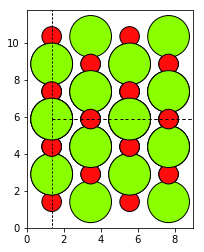

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
atoms = structure.get_ase()
fig, ax = plt.subplots()
plot_atoms(atoms.repeat((2,2,2)), 
           ax, radii=0.8, show_unit_cell=True, 
           rotation=('45x,0y,0z'));

As default, one kind is created per atomic species
(named as the atomic symbol):

In [28]:
structure.get_site_kindnames()

['Mg', 'Mg', 'Mg', 'Mg', 'O1', 'O1', 'O1', 'O1']

However, we may want to specify more than one kind per species
(for example to setup anti-ferromagnetic spin).
We can achieve this by tagging the atoms:

In [8]:
atoms_afm = atoms.copy()
atoms_afm.set_tags([1, 1, 2, 2, 0, 0, 0, 0])
structure_afm = struct_cls(ase=atoms_afm)
structure_afm.get_site_kindnames()

['Mg1', 'Mg1', 'Mg2', 'Mg2', 'O', 'O', 'O', 'O']

..note::

    Since we **always** use the ``EXTERNAL`` keyword for geometry,
    any manipulation to the geometry is undertaken before calling CRYSTAL
    (i.e. we delegate the responsibility for geometry away from CRYSTAL).

### Kind Specific Parameters

Also, we may want to add atom specific inputs to the ``.d12``,
such as initial spin and frozen atoms (for optimisation).

In [18]:
kind_cls = DataFactory("crystal17.kinds")
kind_data = kind_cls(data={
    "kind_names": ["Mg1", "Mg2", "O"],
    "spin_alpha": [True, False, False],
    "spin_beta": [False, True, False],
    "fixed": [False, False, True],
    "ghosts": [False, False, False]
})
display_json(kind_data.kind_dict)

```json
{
  "Mg1": {
    "spin_alpha": true,
    "spin_beta": false,
    "fixed": false,
    "ghosts": false
  },
  "Mg2": {
    "spin_alpha": false,
    "spin_beta": true,
    "fixed": false,
    "ghosts": false
  },
  "O": {
    "spin_alpha": false,
    "spin_beta": false,
    "fixed": true,
    "ghosts": false
  }
}
```

In [21]:
from aiida_crystal17.parsers.raw.inputd12_write import create_atom_properties
atom_props2 = create_atom_properties(structure_afm, kind_data)
atom_props2

{'spin_alpha': [1, 2],
 'spin_beta': [3, 4],
 'unfixed': [1, 2, 3, 4],
 'ghosts': []}

In [22]:
print(write_input(param_dict, basis_sets, atom_props2))

MgO bulk
EXTERNAL
OPTGEOM
FULLOPTG
FRAGMENT
4
1 2 3 4
ENDOPT
END
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.
8 2
1 0 3  2.  0.
1 1 3  6.  0.
99 0
END
DFT
B3LYP
SPIN
END
SHRINK
8 8
ATOMSPIN
4
1 1
2 1
3 -1
4 -1
SMEAR
0.1
ANDERSON
PPAN
END



### Basis Sets

Basis sets are stored as separate
:py:class:`~aiida_crystal17.data.basis_set.BasisSetData` nodes,
in a similar fashion to :py:class:`~aiida.orm.nodes.data.upf.UpfData`.
They are created individually from a text file,
which contains the content of the basis set
and (optionally) a YAML style header section, fenced by ``---``:

In [4]:
mg_basis_path = os.path.join(TEST_DIR, "input_files", "sto3g", 'sto3g_Mg.basis')
with open(mg_basis_path) as handle:
    print(handle.read())

---
author: John Smith
year: 1999
class: sto3g
---
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.


The attributes of the basis set are stored in the database,
and the md5 hash-sum is used to test equivalence of two basis sets.

In [5]:
basis_cls = DataFactory('crystal17.basisset')
mg_basis, created = basis_cls.get_or_create(mg_basis_path)
display_json(mg_basis.attributes)
mg_basis.content

```json
{
  "filename": "sto3g_Mg.basis",
  "md5": "0731ecc3339d2b8736e61add113d0c6f",
  "num_shells": 3,
  "basis_type": "all-electron",
  "element": "Mg",
  "atomic_number": 12,
  "class": "sto3g",
  "year": 1999,
  "author": "John Smith"
}
```

'12 3\n1 0 3  2.  0.\n1 1 3  8.  0.\n1 1 3  2.  0.'

A simpler way to create and refer to basis sets, is *via* a **family group**.
All basis sets in a folder can be read and saved to a named family by:

In [15]:
nfiles, nuploaded = basis_cls.upload_basisset_family(
    os.path.join(TEST_DIR, "input_files", "sto3g"),
    "sto3g", "group of sto3g basis sets",
    extension=".basis", stop_if_existing=False)
basis_cls.get_basis_group_map("sto3g")

{'Mg': <BasisSetData: uuid: a0ed24da-bb26-4352-b9a5-5a1ba2f2fc02 (pk: 72)>,
 'Ni': <BasisSetData: uuid: 47bcf4a1-80ee-416d-a7e4-10641762ad88 (pk: 73)>,
 'O': <BasisSetData: uuid: b90ba90b-a3d9-4fe9-9786-7c8d4e8cf4a9 (pk: 74)>}

or at the command line:

In [70]:
!verdi data crystal17.basis uploadfamily --help

Usage: verdi data crystal17.basis uploadfamily [OPTIONS]

  Upload a family of CRYSTAL Basis Set files.

Options:
  --path PATH                    Path to a folder containing the Basis Set
                                 files
  --ext TEXT                     the file extension to filter by
  --name TEXT                    Name of the BasisSet family  [required]
  -D, --description DESCRIPTION  A description for the family
  --stop-if-existing             Abort when encountering a previously uploaded
                                 Basis Set file
  --dry-run                      do not commit to database or modify
                                 configuration files
  -h, --help                     Show this message and exit.


In [71]:
!verdi data crystal17.basis listfamilies

Family      Num Basis Sets
--------  ----------------
sto3g                    3



Basis families can be searched by the elements they contain:

In [11]:
basis_cls.get_basis_groups(["Ni", "O"])

[<Group: "sto3g" [type crystal17.basisset], of user chrisj_sewell@hotmail.com>]

Basis sets can also be extracted for a particular structure.

In [7]:
basis_cls.get_basissets_from_structure(structure, "sto3g")

{'Mg': <BasisSetData: uuid: a0ed24da-bb26-4352-b9a5-5a1ba2f2fc02 (pk: 72)>,
 'O': <BasisSetData: uuid: b90ba90b-a3d9-4fe9-9786-7c8d4e8cf4a9 (pk: 74)>}

.. important::

    Unlike `aiida-quantumespresso.pw`,
    ``crystal17.main`` uses one basis sets per atomic number only **NOT** per kind.
    This is because, using multiple basis sets per atomic number is rarely used in CRYSTAL17,
    and is limited anyway to only two types per atomic number.

### Symmetry

In the ``main.gui`` file,
as well as using the dimensionality (i.e. periodic boundary conditions),
basis vectors and atomic positions, provided by the ``structure``,
we also need to specify the atomic symmetry of the structure.

:py:class:`~aiida_crystal17.data.symmetry.SymmetryData` is used to store this data, as a validated dictionary.

.. note::

    The ``operations`` are given as a flattened version of the rotation matrix,
    followed by the translation vector.

In [17]:
symmetry_cls = DataFactory("crystal17.symmetry")
edict.pprint(symmetry_cls.data_schema, keycolor="blue")

$schema:     http://json-schema.org/draft-07/schema
additionalProperties: True
properties:
  basis:
    description: whether the symmetry operations are fractional or cartesian
    enum: [fractional, cartesian]
    type: string
  computation:
    description: details of the computation
    type: object
  hall_number:
    description: Hall number defining the symmetry group
    maximum: 530
    minimum: 1
    type: [null, integer]
  operations:
    description: symmetry operations, should at least include the unity
                 operation
    items: {...}
    minItems: 1
    type: array
    uniqueItems: True
required:    [hall_number, operations, basis]
title:       structure symmetry settings
type:        object


The simplest symmetry would be the unitary operator.

In [23]:
symmetry = symmetry_cls(data={
    "hall_number": 1,
    "basis": "fractional",
    "operations": [
        [1,0,0,0,1,0,0,0,1,0,0,0]
    ]
})
symmetry.attributes

{'hall_number': 1, 'basis': 'fractional', 'num_symops': 1}

The full symmetry operations of a periodic structure, 
can be computed using the `crystal17.sym3d` workflow.
This uses the `spglib <https://atztogo.github.io/spglib/>`_ library
to compute symmetries, but with the added constraint that sites
with the same ``Kind`` must be symmetrically equivalent.

In [21]:
!verdi plugin list aiida.workflows crystal17.sym3d

Inputs
        structure:  required  StructureData  
          symprec:  required  Float          Length tolerance for symmetry finding: 0.01 is fairly strict and works well ...
  angle_tolerance:  optional  Float          Angle tolerance for symmetry finding, in the unit of angle degrees
          compute:  optional                 options for computing primitive and standardized structures
         metadata:  optional                 
Outputs
         symmetry:  required  SymmetryData   
        structure:  optional  StructureData  
Exit codes
               10:  The process returned an invalid output
               11:  The process did not register a required output


In [7]:
sym3d_cls = WorkflowFactory("crystal17.sym3d")
builder = sym3d_cls.get_builder()
builder.symprec = 0.01
builder.structure = structure
sym_result = run_get_node(builder)

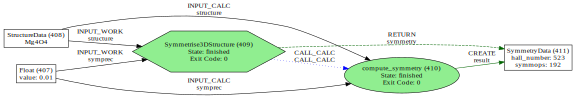

In [16]:
graph = Graph(graph_attr={'size': "8,8!", "rankdir": "LR"})
graph.recurse_ancestors(sym_result.result["symmetry"],
                        annotate_links="both")
graph.graphviz

This workflow can also optionally compute the primitive
and/or standardised form of the structure,
before computing the symmetry of the new structure.

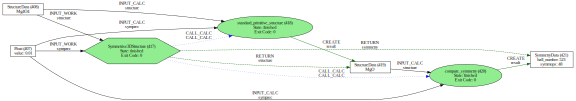

In [20]:
builder.compute.primitive = True
builder.compute.standardize = True
sym_result2 = run_get_node(builder)
graph = Graph(graph_attr={'size': "8,8!", "rankdir": "LR"})
graph.recurse_ancestors(sym_result2.result["structure"],
                        annotate_links="both")
graph.recurse_ancestors(sym_result2.result["symmetry"],
                        annotate_links="both")
graph.graphviz

The other option is to ``idealize`` the structure, which
removes distortions of the unit cell's atomic positions,
compared to the ideal symmetry.

## Setting Up and Running the Calculation

.. seealso::

    AiiDA documentation: :ref:`aiida:working_processes`

:py:class:`~aiida_crystal17.calculations.cry_main.CryMainCalculation`
provides a helper function to create, populate and validate the input builder.

In [40]:
calc_cls = CalculationFactory('crystal17.main')
calc_builder = calc_cls.create_builder(
    parameters={
        "title": "MgO bulk",
        "scf": {"k_points": (8, 8),
                "post_scf": ["PPAN"]}},
    structure=sym_result2.result["structure"],
    symmetry=sym_result2.result["symmetry"],
    bases="sto3g",
    code=Code.objects.get(label="crystal17.basic-mock_runcry17@localhost"),
    metadata={"options": {"resources": {
        "num_machines": 1, "num_mpiprocs_per_machine": 1}}}
)
display_json(calc_builder)

```json
{
  "metadata": {
    "options": {
      "resources": {
        "num_machines": 1,
        "num_mpiprocs_per_machine": 1
      }
    }
  },
  "basissets": {
    "Mg": [
      "uuid: a0ed24da-bb26-4352-b9a5-5a1ba2f2fc02 (pk: 72)"
    ],
    "O": [
      "uuid: b90ba90b-a3d9-4fe9-9786-7c8d4e8cf4a9 (pk: 74)"
    ]
  },
  "parameters": [
    "uuid: 392cf01a-0e01-4c99-8288-0beefae4a95f (unstored)"
  ],
  "structure": [
    "uuid: a0ed9bc2-c981-4e24-9d3e-8f8696e72914 (pk: 419)"
  ],
  "symmetry": [
    "uuid: 3ddc8b2c-f5ec-4359-9b0e-71757bcad052 (pk: 421)"
  ],
  "code": [
    "Remote code 'crystal17.basic-mock_runcry17@localhost' on localhost,",
    "pk: 7, uuid: 6a3db008-b5ab-4308-baf9-d18a39ca4ad5"
  ]
}
```

In order to run the computation,
the builder can be parsed to one of the AiiDA ``run`` (blocking execution) or ``submit`` (non-blocking execution) functions:

In [48]:
result, calcnode = run_get_node(calc_builder)

The process can be monitored on the command line:

In [54]:
!verdi process list -a -p 1 -E 0

  PK  Created    State           Process label                 Process status
----  ---------  --------------  ----------------------------  ----------------
 409  3h ago     ⏹ Finished [0]  Symmetrise3DStructure
 410  3h ago     ⏹ Finished [0]  compute_symmetry
 412  3h ago     ⏹ Finished [0]  Symmetrise3DStructure
 413  3h ago     ⏹ Finished [0]  standard_primitive_structure
 415  3h ago     ⏹ Finished [0]  compute_symmetry
 417  3h ago     ⏹ Finished [0]  Symmetrise3DStructure
 418  3h ago     ⏹ Finished [0]  standard_primitive_structure
 420  3h ago     ⏹ Finished [0]  compute_symmetry
 430  3m ago     ⏹ Finished [0]  CryMainCalculation

Total results: 9

Info: last time an entry changed state: 3m ago (at 03:38:24 on 2019-04-23)


Once the calculation is complete, a ``CalcJobNode`` will be created,
to store the settings and outcome of the computation.
Crucially, if the computation has completed successfully,
the `exit_status` will be **0**. 

This can be assessed on the command line or with the python API.

In [55]:
!verdi process show {calcnode.pk}

Property       Value
-------------  ------------------------------------
type           CalcJobNode
pk             430
uuid           5c6462b3-00a0-4153-ae5f-f780193b5a3f
label
description
ctime          2019-04-23 03:38:12.416391+00:00
mtime          2019-04-23 03:38:24.558649+00:00
process state  Finished
exit status    0
computer       [1] localhost

Inputs      PK    Type
----------  ----  ------------------
basissets
    Mg      72    BasisSetData
    O       74    BasisSetData
code        7     Code
parameters  426   CryInputParamsData
structure   419   StructureData
symmetry    421   SymmetryData

Outputs          PK  Type
-------------  ----  ----------
remote_folder   431  RemoteData
results         433  Dict
retrieved       432  FolderData


In [56]:
print(calcnode.is_finished_ok)
print(calcnode.process_state)
print(calcnode.exit_status)

True
ProcessState.FINISHED
0


If the calculation fails, there are three things that should be checked:

1. The calculation's exit_message
2. The calculation's log messages and scheduler output
3. The `results` output node (if available)

In [57]:
print("Exit Message:", calcnode.exit_message)
from aiida.cmdline.utils.common import get_calcjob_report
print(get_calcjob_report(calcnode))

Exit Message: None
*** 430: None
*** Scheduler output:
running mock runcry17 for input arg: main
*** (empty scheduler errors file)
*** 0 LOG MESSAGES


In [58]:
!verdi process report {calcnode.pk}

*** 430: None
*** Scheduler output:
running mock runcry17 for input arg: main
*** (empty scheduler errors file)
*** 0 LOG MESSAGES


##  Analysis of Outputs

The :py:class:`~aiida_crystal17.graph.Graph` can be used to visualise the calculations provenance graph:

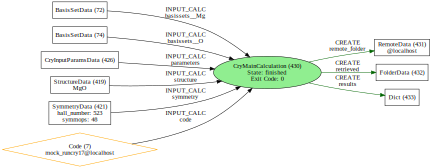

In [59]:
from aiida_crystal17.graph import Graph
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode)
graph.add_incoming(calcnode, annotate_links="both")
graph.add_outgoing(calcnode, annotate_links="both")
graph.graphviz

The `retrieved` `FolderData` output node contains the CRYSTAL17 main input and output file.

In [60]:
calcnode.outputs.retrieved.list_object_names()

['_scheduler-stderr.txt', '_scheduler-stdout.txt', 'main.gui', 'main.out']

The `results` `Dict` output node contains key values extracted from the CRYSTAL17 main output file.

In [61]:
display_json(calcnode.outputs.results.attributes)

```json
{
  "volume": 18.65461525,
  "number_of_assymetric": 2,
  "number_of_atoms": 2,
  "energy_units": "eV",
  "energy": -7380.22160519032,
  "scf_iterations": 7,
  "calculation_type": "restricted closed shell",
  "calculation_spin": false,
  "wall_time_seconds": 3,
  "warnings": [],
  "errors": [],
  "parser_warnings": [],
  "parser_errors": [],
  "ejplugins_version": "0.11.1",
  "parser_class": "CryMainParser",
  "parser_version": "0.4.0"
}
```